In [ ]:
import os
import json
import pickle
import random
from shutil import rmtree

import numpy as np
import torch
import torch.utils.data as data
from PIL import Image
from torchvision import transforms
import _pickle as pickle
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import sys
import uuid

# prepare dataset

The dataset is obtained from bdd100k MOT 2020 (https://doc.bdd100k.com/download.html#mot-2020-images): Multi-object bounding box tracking videos in frames released in 2020.
We only select a subset of videos from their partition "train01", and then we randomly partition them into training and test sets (80%-20%)

The training set contains 80 videos and the test set contains 20 videos. Each video has 30 frames. The dataset also comes with ground truth object detection and object traking labels. There are totally 30772 bounding box labels.


#### Folder structure:
bdd100k\
|-images            # contains frames of each video.\
|-labels.pickle     # contains all the labels\
|-train.txt         # contains names of videos in the training set\
|-test.txt          # contains names of videos in the test set


To load the labels, you can run the following python code:\
    import pickle\
    with open("bdd100k/labels.pickle", "rb") as file:\
         labels = pickle.load(file)
         
The loaded labels is a dictionary where each key is file name of an image, and the value is a list of labels. For example, for the image '0000f77c-62c2a288-0000001.jpg', there is a list of labels:\
{'0000f77c-62c2a288-0000001.jpg': [{'id': '00020715',\
&emsp;   'category': 'car',\
&emsp;   'attributes': {'occluded': False, 'truncated': False, 'crowd': False},\
&emsp;   'box2d': {'x1': 123.8345864661654,\
&emsp;    'x2': 236.16541353383457,\
&emsp;    'y1': 338.3458646616541,\
&emsp;    'y2': 396.5413533834586}}, ...]\
}\
Each label has an id that identifies a unique object. If the same object occurs in two different frames (images), the two labels will have the same object id. If they are not the same object, they will have different object ids. The x and y values define bounding boxes for detected objects.

In [ ]:
# get images
videofiles = []
for filename in os.listdir("bdd100k/images/"):
    videofiles.append(filename)
random.shuffle(videofiles)

In [ ]:
# shrink dataset size to 100 videos and 30 frames per video
for f in videofiles[100:]:
    rmtree(os.path.join("bdd100k/images", f))
    
videofiles = videofiles[0:100]
for f in videofiles:
    for filename in os.listdir(os.path.join("bdd100k/images", f))[30:]:
        os.remove(os.path.join("bdd100k/images", f,  filename))

In [ ]:
# get corresponding labels
labels={}
for filename in os.listdir("bdd100k/labels"):
    if filename[:-5] in videofiles:
        with open(os.path.join("bdd100k/labels", filename), "r") as file:
            f = json.load(file)
        for label in f:
            if int(label['name'][-7:-4]) <= 30:
                labels[label['name']] = label["labels"]

In [ ]:
with open("bdd100k/labels.pickle", "wb") as file:
    pickle.dump(labels, file)

In [ ]:
with open("bdd100k/labels.pickle", "rb") as file:
    labels = pickle.load(file)

In [ ]:
c = 0
for k, v in labels.items():
    c+=len(v)
print("total number of bounding boxex:", c)

total number of bounding boxex: 30772


In [ ]:
# random 80-20 split
random.shuffle(videofiles)
len(videofiles)
with open('./bdd100k/train.txt', 'w') as f:
    f.write("\n".join(videofiles[0:80]))
with open('./bdd100k/test.txt', 'w') as f:
    f.write("\n".join(videofiles[80:100])) 

In [ ]:
labels['0032419c-7d20b300-0000001.jpg']

[{'id': '00036574',
  'category': 'car',
  'attributes': {'crowd': False, 'occluded': False, 'truncated': False},
  'box2d': {'x1': 424.3389943247619,
   'x2': 551.5095869180024,
   'y1': 389.81502568422326,
   'y2': 476.99898864763037}},
 {'id': '00036575',
  'category': 'truck',
  'attributes': {'crowd': False, 'occluded': False, 'truncated': False},
  'box2d': {'x1': 640.649145019849,
   'x2': 692.8929865619383,
   'y1': 369.5589737260786,
   'y2': 418.9940065831094}},
 {'id': '00036576',
  'category': 'truck',
  'attributes': {'crowd': False, 'occluded': True, 'truncated': False},
  'box2d': {'x1': 656.9402353931887,
   'x2': 694.5782717729735,
   'y1': 362.2560711449263,
   'y2': 401.5793927357463}},
 {'id': '00036577',
  'category': 'car',
  'attributes': {'crowd': False, 'occluded': False, 'truncated': False},
  'box2d': {'x1': 600.520366174219,
   'x2': 633.8165448927896,
   'y1': 383.5006298835359,
   'y2': 415.013084742183}},
 {'id': '00036578',
  'category': 'truck',
  'attr

In [ ]:
labels['0000f77c-62c2a288-0000001.jpg'][0]

{'id': '00020715',
 'category': 'car',
 'attributes': {'occluded': False, 'truncated': False, 'crowd': False},
 'box2d': {'x1': 123.8345864661654,
  'x2': 236.16541353383457,
  'y1': 338.3458646616541,
  'y2': 396.5413533834586}}

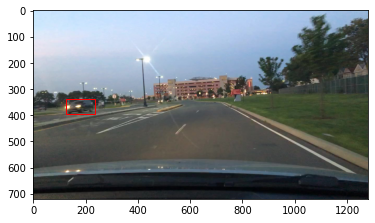

In [ ]:
im = Image.open('bdd100k/images/0000f77c-62c2a288/0000f77c-62c2a288-0000001.jpg')

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(im)

# Create a Rectangle patch
bb = labels['0000f77c-62c2a288-0000001.jpg'][0]['box2d']
x = bb['x1']
y = bb['y1']
width = bb['x2'] - bb['x1']
height = bb['y2'] - bb['y1']
rect = patches.Rectangle((bb['x1'], bb['y1']), width, height, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

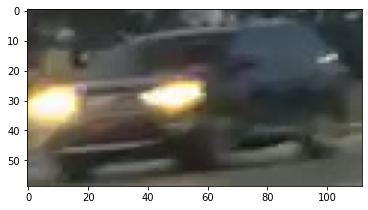

In [ ]:
# Create figure and axes
fig, ax = plt.subplots()

img = cv2.imread('bdd100k/images/0000f77c-62c2a288/0000f77c-62c2a288-0000001.jpg')
cropped = img[round(bb['y1']):round(bb['y2']),round(bb['x1']):round(bb['x2']),:]
# Display the image
ax.imshow(Image.fromarray(cropped[:,:,::-1]))

# dataloader and preprocess dataset

In [ ]:
# Dataset for training relation network
# returns (image_crop1, image_crop2, label) where label can be 0 for "not same object" or 1 for "same object"

class TrackingData(data.Dataset):

    def __init__(self, transform=None, partition="train"):
        with open("bdd100k/labels.pickle", "rb") as file:
            self.labels = pickle.load(file)
        with open('bdd100k/'+partition+'.txt', 'r') as f:
            self.filenames = f.read().split("\n")
        self.transform = transform
        self.data = []
        self.data_attributes = []
        for i, name in enumerate(self.filenames):
            print("loading",i, name)
            self.load_video(name)
            
    
    # load all bounding boxes for a video
    # for each video, we prepare data of the form (image1, image2, label) such that
    # label = 1 means that the two images are same object obtained in two consecutive frames
    # label = 0 means that the two images are different objects obtained in two consecutive frames
    # If there are k objects each frame and t frames,
    # we will have k*(t-1) positive examples and k*(k-1)*(t-1) negative examples
    def load_video(self, filename):
        objects_in_last_frame = []
        for imagename in os.listdir("bdd100k/images/"+filename):
            objects_in_new_frame = []
            image = cv2.imread("bdd100k/images/"+filename+"/"+imagename)
            labels = self.labels[imagename]
            
            # get objects
            for label in labels:
                bb = label['box2d']
                crop_image = Image.fromarray(image[round(bb['y1']):round(bb['y2']),round(bb['x1']):round(bb['x2']),:][:,:,::-1])
                id_label = int(label['id'])
                objects_in_new_frame.append((id_label, crop_image, label))
                
            # generate positive and negative examples
            for object_new in objects_in_new_frame:
                for object_last in objects_in_last_frame:
                    label = 1 if object_new[0]==object_last[0] else 0
                    self.data.append((object_new[1], object_last[1], label))
                    self.data_attributes.append((object_new[2], object_last[2], [label]))
                    
            # update objects_in_last_frame
            objects_in_last_frame = objects_in_new_frame
        return None

    
    
    def __len__(self):
        return len(self.data)

    
    # return (image1, image2, label)
    def __getitem__(self, index):
        if self.transform is not None:
            (image1, image2, label) = self.data[index]
            return self.transform(image1), self.transform(image2), label
        else:
            return self.data[index]
        
    def add_transform(self, transform):
        self.transform = transform

In [ ]:
tfms = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),transforms.Resize((224,224))])
dataset = TrackingData(transform=tfms, partition="train")

In [ ]:
len(dataset)

335948

1
0


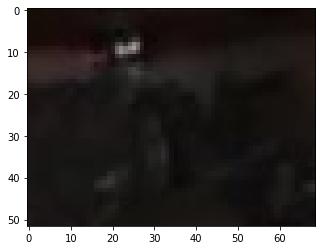

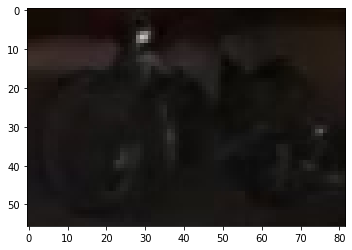

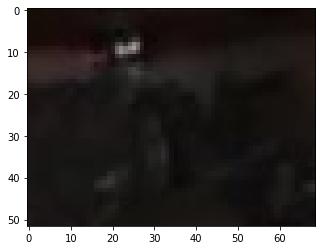

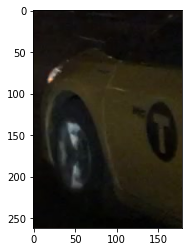

In [ ]:
# print first 15 data to make sure everything is okay.
dataset.add_transform(None)
for i in range(2):
    img1, img2, label = dataset[i]
    fig, ax = plt.subplots()
    ax.imshow(img1)
    fig, ax = plt.subplots()
    ax.imshow(img2)
    print(label)

# Visual Appereance Model

In [ ]:
# Model definition

# feature size: 1280, 7, 7 
# concate -> 2560, 7, 7
# 3*3 conv, batch norm, relu, Dropout -> 2560, 5, 5
# AvgPool2d(2) -> 2560, 2, 2
# 2*2 conv, batch norm, relu, Dropout -> 5120, 1, 1
# FC batch norm ReLU, Dropout -> 256
# FC sigmoid -> 1 score

class convRelationNN(nn.Module):
    def __init__(self):
        super(convRelationNN, self).__init__()
        # relation network
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(2560, 2560, kernel_size=3),
            nn.BatchNorm2d(2560),
            nn.ReLU(),
            nn.Dropout(p=0.25))
        self.pool1 = nn.AvgPool2d(2)
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(2560, 5120, kernel_size=2),
            nn.BatchNorm2d(5120),
            nn.ReLU(),
            nn.Dropout(p=0.25))
        self.layer3 = torch.nn.Sequential(
            nn.Linear(5120, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.25))
        self.layer4 = torch.nn.Sequential(
            nn.Linear(256, 1),
            nn.Sigmoid())
        
    def forward(self, input):
        x = self.layer1(input)
        x = self.pool1(x)
        x = self.layer2(x)
        x = torch.flatten(x, 1)
        x = self.layer3(x)
        x = self.layer4(x)      

        return x
    
class fcRelationNN(nn.Module):
    def __init__(self):
        super(fcRelationNN, self).__init__()
        # relation network
        self.pool1 = nn.AdaptiveAvgPool2d(1)
        self.layer1 = torch.nn.Sequential(
            nn.Linear(2560, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(p=0.25))
        self.layer2 = torch.nn.Sequential(
            nn.Linear(1024, 1),
            nn.Sigmoid())
        
    def forward(self, input):
        x = self.pool1(input)
        x = torch.flatten(x, 1)
        x = self.layer1(x)
        x = self.layer2(x)      
        return x

class AppearanceNN(nn.Module):
    def __init__(self, conv=False):
        super(AppearanceNN, self).__init__()
        # we use pre-trained efficientnet_b0 for feature extraction
        self.featureNN = models.efficientnet_b0(pretrained=True)
        self.bn = nn.BatchNorm2d(2560)
        
        # relation network
        self.relationNN = convRelationNN() if conv else fcRelationNN()
        
    def forward(self, input):
        x = self.featureNN.features(input[0])
        y = self.featureNN.features(input[1])
        x = torch.cat((x,y), dim=1)
        x = self.bn(x)
        x = self.relationNN(x)    

        return x

In [ ]:
model = AppearanceNN()
# model((dataset[0][0].unsqueeze(0), dataset[0][1].unsqueeze(0)))

In [ ]:
dataset.add_transform(tfms)
loader_train = torch.utils.data.DataLoader(dataset, batch_size=8,
                                          shuffle=True)
for i, data in enumerate(loader_train):
    result = model(data)
    print(data[0].shape, data[2].shape)
    break

torch.Size([8, 3, 224, 224]) torch.Size([8])


In [ ]:
result

tensor([[0.4488],
        [0.3810],
        [0.5169],
        [0.5294],
        [0.4583],
        [0.3166],
        [0.4936],
        [0.3680]], grad_fn=<SigmoidBackward0>)

In [ ]:
# Optimizer 
class Solver(object):
    def __init__(self, model, dataloader, dataloader_test=None, lr=0.01, momentum=0.9, num_epoches=2, device="cpu", 
                 print_freq=10, fix_feature_model=True):
        self.model = model
        self.dataloader = dataloader
        if dataloader_test == None:
            self.criterion = nn.BCELoss()
            if fix_feature_model:
                self.optimizer = torch.optim.SGD(model.relationNN.parameters(), lr=lr, momentum=momentum)
            else:
                self.optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
            self.fix_feature_model = fix_feature_model
            self.num_epoches = num_epoches
        self.dataloader_test = dataloader_test
        self.print_freq = print_freq
        
    def train(self):
        if self.fix_feature_model:
            self.model.relationNN.train()
            self.model.featureNN.eval()
        else:
            self.model.train()
        self.training_loss=[]
        self.training_accuracy=[]
        
        for t in range(self.num_epoches):
            epoch_loss = []
            epoch_accuracy = []
            for i, data in enumerate(self.dataloader):
                # get the inputs; data is (image1, image2, label)
                data = [d.to(device) for d in data]
                labels = data[2].reshape((-1,1))
                
                # zero the parameter gradients
                self.optimizer.zero_grad()

                # forward + backward + optimize
                outputs = self.model(data)
                loss = self.criterion(outputs, labels.float())
                loss.backward()
                self.optimizer.step()
                
                # stats
                epoch_loss.append(loss.item())
                acc = self.get_accuracy(outputs, labels)
                epoch_accuracy.append(acc)
                
                if i %  self.print_freq == 0:
                    print("epoch", t, "batch", i, "loss", sum(epoch_loss[-self.print_freq:])/self.print_freq, 
                          "accuracy", sum(epoch_accuracy[-self.print_freq:])/self.print_freq)
                
            self.training_loss.append(epoch_loss)
            self.training_accuracy.append(epoch_accuracy)
        
        return self.model, self.training_loss,  self.training_accuracy
    
    def get_accuracy(self, outputs, labels):  
        correct_count = ((outputs>0.5).int() == labels).sum()
        return torch.round(correct_count / len(labels) * 100).item()
    
    def evaluate(self):
        self.model.eval()
        test_accuracy = []
        with torch.no_grad():
            for i, data in enumerate(self.dataloader_test):
                # get the inputs; data is a list of [inputs, labels]
                data = [d.to(device) for d in data]
                labels = data[2].reshape((-1,1))

                # get accuracy
                outputs = self.model(data)
                acc = self.get_accuracy(outputs, labels)
                test_accuracy.append(acc)

                if i % self.print_freq == 0:
                    print("batch", i, "accuracy", sum(test_accuracy[-self.print_freq:])/self.print_freq)

        test_accuracy = sum(test_accuracy)/len(test_accuracy)
        return   test_accuracy

# train: binary classification

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# normalize for the pre-trained model
tfms = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),transforms.Resize((224,224))])

# load the data                 
dataset_train = TrackingData(partition="train", transform=tfms)
# dataset_test = TrackingData(partition="test", transform=tfms)

# data loader
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=16,
                                          shuffle=True)
# loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1,
#                                           shuffle=False)


cuda
loading 0 00378858-c5f802ac
loading 1 0028cbbf-92f30408
loading 2 002b485a-3f6603f2
loading 3 0051e391-d32a618e
loading 4 00131ea7-624f538d
loading 5 002685b6-856c17f7
loading 6 006bff20-752bd845
loading 7 0070bc56-4c0bb2d5
loading 8 004ea016-0b1932a7
loading 9 0075a5b0-9a8d5dbb
loading 10 0049e5b8-afda7206
loading 11 002d290d-89f4e5c0
loading 12 0070bc56-8d8cfd82
loading 13 007aeb45-eef41701
loading 14 0081c36b-30bff234
loading 15 007da0eb-8cca23d7
loading 16 0034a363-24f318c4
loading 17 00207869-902288d1
loading 18 0048f391-e9bfaf62
loading 19 002d290d-f9108a13
loading 20 002d290d-90f2bab2
loading 21 0062f18d-f8cd3a65
loading 22 001c5339-13a07470
loading 23 0075b179-8e09869a
loading 24 004071a4-ef4bf541
loading 25 0000f77c-62c2a288
loading 26 006fdb67-a1455b77
loading 27 007aeb45-9330e852
loading 28 002cd38e-ebe888e1
loading 29 007ae77f-79995643
loading 30 005c4fd3-cb4d6287
loading 31 0070bc56-29bcc943
loading 32 0030f434-3eb4a3a9
loading 33 0000f77c-cb820c98
loading 34 007aeb45

In [ ]:
# convRelationNN
# train relationNN only. fix featureNN

num_epoches = 1

# model
model = AppearanceNN(conv=True).to(device)

# train the model
solver = Solver(model, loader_train, num_epoches=num_epoches, device=device, print_freq=100, fix_feature_model=True)
model, loss_training, training_accuracy = solver.train()

epoch 0 batch 0 loss 0.009253189563751221 accuracy 0.06
epoch 0 batch 100 loss 0.3335137475002557 accuracy 91.38
epoch 0 batch 200 loss 0.24925940174609423 accuracy 92.68
epoch 0 batch 300 loss 0.23421923760324717 accuracy 92.93
epoch 0 batch 400 loss 0.2081123948097229 accuracy 93.29
epoch 0 batch 500 loss 0.20211333142593502 accuracy 93.82
epoch 0 batch 600 loss 0.18154259890317917 accuracy 94.98
epoch 0 batch 700 loss 0.20698679208755494 accuracy 93.33
epoch 0 batch 800 loss 0.19267294442281127 accuracy 93.18
epoch 0 batch 900 loss 0.1904148550890386 accuracy 93.88
epoch 0 batch 1000 loss 0.2082230734080076 accuracy 91.89
epoch 0 batch 1100 loss 0.17785169085487723 accuracy 93.87
epoch 0 batch 1200 loss 0.17452372495085 accuracy 93.88
epoch 0 batch 1300 loss 0.19748089250177145 accuracy 92.85
epoch 0 batch 1400 loss 0.15638085778802632 accuracy 94.44
epoch 0 batch 1500 loss 0.16413299445062876 accuracy 94.09
epoch 0 batch 1600 loss 0.173911857791245 accuracy 93.53
epoch 0 batch 1700

KeyboardInterrupt: 

In [ ]:
# convRelationNN
# train both relationNN and featureNN

num_epoches = 1

# model
model = AppearanceNN(conv=True).to(device)

# train the model
solver = Solver(model, loader_train, num_epoches=num_epoches, device=device, print_freq=100, fix_feature_model=False)
model, loss_training, training_accuracy = solver.train()

epoch 0 batch 0 loss 0.006159987449645996 accuracy 0.75
epoch 0 batch 100 loss 0.3083283233270049 accuracy 93.05
epoch 0 batch 200 loss 0.25105656396597625 accuracy 92.93
epoch 0 batch 300 loss 0.22295911759138107 accuracy 93.17
epoch 0 batch 400 loss 0.22825583528727292 accuracy 93.57
epoch 0 batch 500 loss 0.22504189845174552 accuracy 93.79
epoch 0 batch 600 loss 0.21949371751397848 accuracy 93.08
epoch 0 batch 700 loss 0.20823242776095868 accuracy 93.5
epoch 0 batch 800 loss 0.19555529102683067 accuracy 93.96
epoch 0 batch 900 loss 0.17765896294265984 accuracy 94.37
epoch 0 batch 1000 loss 0.1694793587550521 accuracy 94.09
epoch 0 batch 1100 loss 0.1890670822560787 accuracy 93.67
epoch 0 batch 1200 loss 0.19673572355881333 accuracy 93.5
epoch 0 batch 1300 loss 0.16698604755103588 accuracy 93.7
epoch 0 batch 1400 loss 0.21098373707383872 accuracy 93.13
epoch 0 batch 1500 loss 0.17465000577270984 accuracy 93.59
epoch 0 batch 1600 loss 0.18179976299405098 accuracy 93.35
epoch 0 batch 1

epoch 0 batch 14000 loss 0.06685760715277865 accuracy 97.9
epoch 0 batch 14100 loss 0.05910380063112825 accuracy 98.26
epoch 0 batch 14200 loss 0.05547009984962642 accuracy 98.32
epoch 0 batch 14300 loss 0.05499427926028147 accuracy 98.26
epoch 0 batch 14400 loss 0.06271349372458644 accuracy 98.2
epoch 0 batch 14500 loss 0.07483771634055301 accuracy 98.08
epoch 0 batch 14600 loss 0.08705841244664043 accuracy 97.3
epoch 0 batch 14700 loss 0.06243774818023667 accuracy 98.32
epoch 0 batch 14800 loss 0.07221937214024365 accuracy 97.89
epoch 0 batch 14900 loss 0.06990304476115852 accuracy 97.76
epoch 0 batch 15000 loss 0.0641859418177046 accuracy 98.32
epoch 0 batch 15100 loss 0.04856189468177036 accuracy 98.68
epoch 0 batch 15200 loss 0.04717087323428132 accuracy 98.62
epoch 0 batch 15300 loss 0.05291440553031862 accuracy 98.38
epoch 0 batch 15400 loss 0.03541952405124903 accuracy 98.92
epoch 0 batch 15500 loss 0.05577380651142448 accuracy 98.37
epoch 0 batch 15600 loss 0.06011365021346137

KeyboardInterrupt: 

In [ ]:
# save model
torch.save(model, "AppearanceNN_conv_all_0")

In [ ]:
# fcRelationNN
# train both relationNN and featureNN

num_epoches = 1

# model
model = AppearanceNN(conv=False).to(device)

# train the model
solver = Solver(model, loader_train, num_epoches=num_epoches, device=device, print_freq=100, fix_feature_model=False)
model, loss_training, training_accuracy = solver.train()

epoch 0 batch 0 loss 0.007924092411994934 accuracy 0.31
epoch 0 batch 100 loss 0.33261134543077786 accuracy 92.64
epoch 0 batch 200 loss 0.28072944955900314 accuracy 93.07
epoch 0 batch 300 loss 0.31716356293298303 accuracy 91.43
epoch 0 batch 400 loss 0.34292919363826513 accuracy 91.64
epoch 0 batch 500 loss 0.29306380566209556 accuracy 93.47
epoch 0 batch 600 loss 0.3458004136011004 accuracy 91.33
epoch 0 batch 700 loss 0.30803494011983273 accuracy 92.71
epoch 0 batch 800 loss 0.46908529215492306 accuracy 91.55
epoch 0 batch 900 loss 0.39096067221835257 accuracy 91.81
epoch 0 batch 1000 loss 0.2853399042505771 accuracy 93.44
epoch 0 batch 1100 loss 0.3050819994136691 accuracy 92.8
epoch 0 batch 1200 loss 0.31435624400153755 accuracy 93.07
epoch 0 batch 1300 loss 0.34393303126096725 accuracy 93.25
epoch 0 batch 1400 loss 0.32159786246716976 accuracy 92.65
epoch 0 batch 1500 loss 0.3484205725416541 accuracy 92.72
epoch 0 batch 1600 loss 0.3226844382844865 accuracy 93.14
epoch 0 batch 1

KeyboardInterrupt: 

In [ ]:
string = """epoch 0 batch 0 loss 0.007924092411994934 accuracy 0.31
epoch 0 batch 100 loss 0.33261134543077786 accuracy 92.64
epoch 0 batch 200 loss 0.28072944955900314 accuracy 93.07
epoch 0 batch 300 loss 0.31716356293298303 accuracy 91.43
epoch 0 batch 400 loss 0.34292919363826513 accuracy 91.64
epoch 0 batch 500 loss 0.29306380566209556 accuracy 93.47
epoch 0 batch 600 loss 0.3458004136011004 accuracy 91.33
epoch 0 batch 700 loss 0.30803494011983273 accuracy 92.71
epoch 0 batch 800 loss 0.46908529215492306 accuracy 91.55
epoch 0 batch 900 loss 0.39096067221835257 accuracy 91.81
epoch 0 batch 1000 loss 0.2853399042505771 accuracy 93.44
epoch 0 batch 1100 loss 0.3050819994136691 accuracy 92.8
epoch 0 batch 1200 loss 0.31435624400153755 accuracy 93.07
epoch 0 batch 1300 loss 0.34393303126096725 accuracy 93.25
epoch 0 batch 1400 loss 0.32159786246716976 accuracy 92.65
epoch 0 batch 1500 loss 0.3484205725416541 accuracy 92.72
epoch 0 batch 1600 loss 0.3226844382844865 accuracy 93.14
epoch 0 batch 1700 loss 0.2627694107219577 accuracy 93.74
epoch 0 batch 1800 loss 0.2834836906939745 accuracy 93.06
epoch 0 batch 1900 loss 0.30137300793081523 accuracy 93.33
epoch 0 batch 2000 loss 0.4841198837570846 accuracy 93.37
epoch 0 batch 2100 loss 0.3618619970604777 accuracy 91.98
epoch 0 batch 2200 loss 0.45707114491611717 accuracy 92.61
epoch 0 batch 2300 loss 0.38606600303202865 accuracy 92.54
epoch 0 batch 2400 loss 0.3193523269332945 accuracy 93.54
epoch 0 batch 2500 loss 0.33196688441559674 accuracy 93.16
epoch 0 batch 2600 loss 0.4125624676793814 accuracy 89.97
epoch 0 batch 2700 loss 0.33917055930942297 accuracy 91.84
epoch 0 batch 2800 loss 0.331664408184588 accuracy 92.12
epoch 0 batch 2900 loss 0.3355199812911451 accuracy 92.45
epoch 0 batch 3000 loss 0.3445921810530126 accuracy 92.51
epoch 0 batch 3100 loss 0.3485542212426662 accuracy 92.1
epoch 0 batch 3200 loss 0.29433935213834045 accuracy 94.02
epoch 0 batch 3300 loss 0.3792703741788864 accuracy 91.77
epoch 0 batch 3400 loss 0.31237514173611997 accuracy 93.25
epoch 0 batch 3500 loss 0.3634228887781501 accuracy 91.77
epoch 0 batch 3600 loss 0.3519798498041928 accuracy 92.14
epoch 0 batch 3700 loss 0.319245698582381 accuracy 92.79
epoch 0 batch 3800 loss 0.2946027062647045 accuracy 93.8
epoch 0 batch 3900 loss 0.29877365317195653 accuracy 93.43
epoch 0 batch 4000 loss 0.34544456131756307 accuracy 92.82
epoch 0 batch 4100 loss 0.3373367384262383 accuracy 91.79
epoch 0 batch 4200 loss 0.28790173327550295 accuracy 93.05
epoch 0 batch 4300 loss 0.3259768148511648 accuracy 92.17
epoch 0 batch 4400 loss 0.29210083223879335 accuracy 93.01
epoch 0 batch 4500 loss 0.3077345863543451 accuracy 92.79
epoch 0 batch 4600 loss 0.38077153883874415 accuracy 91.02
epoch 0 batch 4700 loss 0.38067759718745947 accuracy 91.71
epoch 0 batch 4800 loss 0.2835137201845646 accuracy 93.65
epoch 0 batch 4900 loss 0.2949200021289289 accuracy 93.03
epoch 0 batch 5000 loss 0.29656307566910983 accuracy 93.07"""

lines = [float(line.split(" ")[-1]) for line in string.split("\n")[1:]]
lines2 = [float(line.split(" ")[-3]) for line in string.split("\n")[1:]]

with open("fc_both_training_acc.pickle", "wb") as file:
    pickle.dump(lines, file)
with open("fc_both_training_loss.pickle", "wb") as file:
    pickle.dump(lines2, file)
    
string = """epoch 0 batch 0 loss 0.009253189563751221 accuracy 0.06
epoch 0 batch 100 loss 0.3335137475002557 accuracy 91.38
epoch 0 batch 200 loss 0.24925940174609423 accuracy 92.68
epoch 0 batch 300 loss 0.23421923760324717 accuracy 92.93
epoch 0 batch 400 loss 0.2081123948097229 accuracy 93.29
epoch 0 batch 500 loss 0.20211333142593502 accuracy 93.82
epoch 0 batch 600 loss 0.18154259890317917 accuracy 94.98
epoch 0 batch 700 loss 0.20698679208755494 accuracy 93.33
epoch 0 batch 800 loss 0.19267294442281127 accuracy 93.18
epoch 0 batch 900 loss 0.1904148550890386 accuracy 93.88
epoch 0 batch 1000 loss 0.2082230734080076 accuracy 91.89
epoch 0 batch 1100 loss 0.17785169085487723 accuracy 93.87
epoch 0 batch 1200 loss 0.17452372495085 accuracy 93.88
epoch 0 batch 1300 loss 0.19748089250177145 accuracy 92.85
epoch 0 batch 1400 loss 0.15638085778802632 accuracy 94.44
epoch 0 batch 1500 loss 0.16413299445062876 accuracy 94.09
epoch 0 batch 1600 loss 0.173911857791245 accuracy 93.53
epoch 0 batch 1700 loss 0.1549014993943274 accuracy 94.74
epoch 0 batch 1800 loss 0.15215951811522246 accuracy 94.04
epoch 0 batch 1900 loss 0.20200377458706498 accuracy 93.39
epoch 0 batch 2000 loss 0.15027186824008823 accuracy 94.49
epoch 0 batch 2100 loss 0.14615469437092543 accuracy 94.46
epoch 0 batch 2200 loss 0.15469804173335433 accuracy 94.06
epoch 0 batch 2300 loss 0.17838707914575935 accuracy 93.44
epoch 0 batch 2400 loss 0.1394297531992197 accuracy 94.49
epoch 0 batch 2500 loss 0.1600206959247589 accuracy 94.04
epoch 0 batch 2600 loss 0.14378990650177 accuracy 94.12
epoch 0 batch 2700 loss 0.13988659406080842 accuracy 94.81
epoch 0 batch 2800 loss 0.15234894575551153 accuracy 94.34
epoch 0 batch 2900 loss 0.13685183538123966 accuracy 94.8
epoch 0 batch 3000 loss 0.122488170908764 accuracy 95.65
epoch 0 batch 3100 loss 0.1527592246234417 accuracy 93.66
epoch 0 batch 3200 loss 0.1292353929951787 accuracy 95.28
epoch 0 batch 3300 loss 0.11885957261547446 accuracy 95.53
epoch 0 batch 3400 loss 0.11598265424370766 accuracy 96.0
epoch 0 batch 3500 loss 0.12523080047219992 accuracy 95.16
epoch 0 batch 3600 loss 0.12688668310642243 accuracy 95.4
epoch 0 batch 3700 loss 0.1132633915822953 accuracy 96.44
epoch 0 batch 3800 loss 0.10993322096765042 accuracy 95.58
epoch 0 batch 3900 loss 0.10412136118859053 accuracy 96.49
epoch 0 batch 4000 loss 0.11928633071482181 accuracy 95.85
epoch 0 batch 4100 loss 0.10341520786751061 accuracy 96.09
epoch 0 batch 4200 loss 0.09893381683621555 accuracy 96.27
epoch 0 batch 4300 loss 0.10733152675442398 accuracy 96.26
epoch 0 batch 4400 loss 0.11498923482373356 accuracy 96.17
epoch 0 batch 4500 loss 0.1098524589277804 accuracy 96.17
epoch 0 batch 4600 loss 0.11086514436174184 accuracy 95.95
epoch 0 batch 4700 loss 0.09716095408424735 accuracy 96.81
epoch 0 batch 4800 loss 0.10747864552773535 accuracy 95.89
epoch 0 batch 4900 loss 0.09913537799846381 accuracy 96.2
epoch 0 batch 5000 loss 0.10391748629044742 accuracy 96.15"""

lines = [float(line.split(" ")[-1]) for line in string.split("\n")[1:]]
lines2 = [float(line.split(" ")[-3]) for line in string.split("\n")[1:]]

with open("conv_relation_only_training_acc.pickle", "wb") as file:
    pickle.dump(lines, file)
with open("conv_relation_only_training_loss.pickle", "wb") as file:
    pickle.dump(lines2, file)
    
string = """epoch 0 batch 0 loss 0.006159987449645996 accuracy 0.75
epoch 0 batch 100 loss 0.3083283233270049 accuracy 93.05
epoch 0 batch 200 loss 0.25105656396597625 accuracy 92.93
epoch 0 batch 300 loss 0.22295911759138107 accuracy 93.17
epoch 0 batch 400 loss 0.22825583528727292 accuracy 93.57
epoch 0 batch 500 loss 0.22504189845174552 accuracy 93.79
epoch 0 batch 600 loss 0.21949371751397848 accuracy 93.08
epoch 0 batch 700 loss 0.20823242776095868 accuracy 93.5
epoch 0 batch 800 loss 0.19555529102683067 accuracy 93.96
epoch 0 batch 900 loss 0.17765896294265984 accuracy 94.37
epoch 0 batch 1000 loss 0.1694793587550521 accuracy 94.09
epoch 0 batch 1100 loss 0.1890670822560787 accuracy 93.67
epoch 0 batch 1200 loss 0.19673572355881333 accuracy 93.5
epoch 0 batch 1300 loss 0.16698604755103588 accuracy 93.7
epoch 0 batch 1400 loss 0.21098373707383872 accuracy 93.13
epoch 0 batch 1500 loss 0.17465000577270984 accuracy 93.59
epoch 0 batch 1600 loss 0.18179976299405098 accuracy 93.35
epoch 0 batch 1700 loss 0.18250596910715103 accuracy 93.09
epoch 0 batch 1800 loss 0.15041292952373625 accuracy 94.85
epoch 0 batch 1900 loss 0.16960195619612933 accuracy 93.68
epoch 0 batch 2000 loss 0.1498872522637248 accuracy 94.86
epoch 0 batch 2100 loss 0.13383158180862664 accuracy 95.65
epoch 0 batch 2200 loss 0.13795517305843533 accuracy 95.21
epoch 0 batch 2300 loss 0.15289618516340853 accuracy 95.48
epoch 0 batch 2400 loss 0.1254794175736606 accuracy 95.73
epoch 0 batch 2500 loss 0.13687597621232273 accuracy 96.14
epoch 0 batch 2600 loss 0.1178601060807705 accuracy 96.44
epoch 0 batch 2700 loss 0.11898944179527461 accuracy 96.09
epoch 0 batch 2800 loss 0.11608043256215751 accuracy 95.84
epoch 0 batch 2900 loss 0.1165462289378047 accuracy 95.92
epoch 0 batch 3000 loss 0.12089140464551747 accuracy 95.71
epoch 0 batch 3100 loss 0.08786833737976849 accuracy 97.24
epoch 0 batch 3200 loss 0.10730948431417346 accuracy 96.43
epoch 0 batch 3300 loss 0.09185971354600042 accuracy 97.12
epoch 0 batch 3400 loss 0.0985759101388976 accuracy 96.57
epoch 0 batch 3500 loss 0.1203550059068948 accuracy 96.09
epoch 0 batch 3600 loss 0.0955104648694396 accuracy 96.81
epoch 0 batch 3700 loss 0.09909208695404231 accuracy 96.33
epoch 0 batch 3800 loss 0.12222047288902103 accuracy 95.57
epoch 0 batch 3900 loss 0.10054191951174289 accuracy 96.93
epoch 0 batch 4000 loss 0.09921391214244067 accuracy 97.24
epoch 0 batch 4100 loss 0.11521617983467877 accuracy 95.91
epoch 0 batch 4200 loss 0.1012508731521666 accuracy 96.57
epoch 0 batch 4300 loss 0.09600707482546568 accuracy 96.86
epoch 0 batch 4400 loss 0.10065837310627103 accuracy 96.88
epoch 0 batch 4500 loss 0.09670989803038538 accuracy 97.04
epoch 0 batch 4600 loss 0.09927529951557518 accuracy 96.88
epoch 0 batch 4700 loss 0.0974165983311832 accuracy 96.58
epoch 0 batch 4800 loss 0.117191402297467 accuracy 96.52
epoch 0 batch 4900 loss 0.11713451785966754 accuracy 96.66
epoch 0 batch 5000 loss 0.07874808759661392 accuracy 97.29"""

lines = [float(line.split(" ")[-1]) for line in string.split("\n")[1:]]
lines2 = [float(line.split(" ")[-3]) for line in string.split("\n")[1:]]

with open("conv_both_training_acc.pickle", "wb") as file:
    pickle.dump(lines, file)
with open("conv_both_training_loss.pickle", "wb") as file:
    pickle.dump(lines2, file)

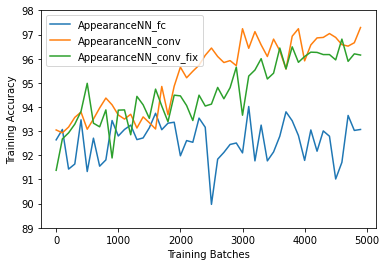

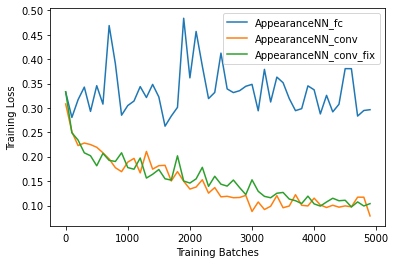

In [ ]:
# plot results
import pickle
import numpy as np
import matplotlib.pyplot as plt

with open("fc_both_training_acc.pickle", "rb") as file:
    fc_both_training_acc = pickle.load(file)
with open("conv_both_training_acc.pickle", "rb") as file:
    conv_both_training_acc = pickle.load(file)
with open("conv_relation_only_training_acc.pickle", "rb") as file:
    conv_relation_only_training_acc = pickle.load(file)
    
# plt.yscale("log")
fig, ax = plt.subplots()
plt.plot(range(len(fc_both_training_acc)), fc_both_training_acc, label="AppearanceNN_fc")
plt.plot(range(len(fc_both_training_acc)), conv_both_training_acc, label="AppearanceNN_conv")
plt.plot(range(len(fc_both_training_acc)), conv_relation_only_training_acc, label="AppearanceNN_conv_fix")
plt.legend(loc="upper left")
plt.xticks([0, 10, 20, 30, 40, 50], [0, 1000, 2000, 3000, 4000, 5000])
plt.xlabel("Training Batches")
plt.ylabel("Training Accuracy")
ax = plt.gca()
ax.set_ylim([89, 98])
fig.savefig("2_way_training_acc.pdf", 
               bbox_inches='tight', 
               transparent=True,
               pad_inches=0)
plt.show()

with open("fc_both_training_loss.pickle", "rb") as file:
    fc_both_training_loss = pickle.load(file)
with open("conv_both_training_loss.pickle", "rb") as file:
    conv_both_training_loss = pickle.load(file)
with open("conv_relation_only_training_loss.pickle", "rb") as file:
    conv_relation_only_training_loss = pickle.load(file)
    
# plt.yscale("log")
fig, ax = plt.subplots()
plt.plot(range(len(fc_both_training_acc)), fc_both_training_loss, label="AppearanceNN_fc")
plt.plot(range(len(fc_both_training_acc)), conv_both_training_loss, label="AppearanceNN_conv")
plt.plot(range(len(fc_both_training_acc)), conv_relation_only_training_loss, label="AppearanceNN_conv_fix")
plt.legend(loc="upper right")
plt.xticks([0, 10, 20, 30, 40, 50], [0, 1000, 2000, 3000, 4000, 5000])
plt.xlabel("Training Batches")
plt.ylabel("Training Loss")
fig.savefig("2_way_training_loss.pdf", 
               bbox_inches='tight', 
               transparent=True,
               pad_inches=0)
plt.show()

In [ ]:
# train for a second epoch with learning rate 0.002
num_epoches = 1

# model
model = torch.load("AppearanceNN_conv_all_0")

# train the model
solver = Solver(model, loader_train, lr=0.002, num_epoches=num_epoches, device=device, print_freq=100, fix_feature_model=False)
model, loss_training, training_accuracy = solver.train()

epoch 0 batch 0 loss 0.0007813481986522674 accuracy 0.94
epoch 0 batch 100 loss 0.04448113761143759 accuracy 98.62
epoch 0 batch 200 loss 0.04865538273588754 accuracy 98.62
epoch 0 batch 300 loss 0.03479887130437419 accuracy 98.92
epoch 0 batch 400 loss 0.05333154069900047 accuracy 98.68
epoch 0 batch 500 loss 0.052680392814800144 accuracy 98.67
epoch 0 batch 600 loss 0.059881296155508607 accuracy 98.32
epoch 0 batch 700 loss 0.06134716436965391 accuracy 98.26
epoch 0 batch 800 loss 0.03568944214493967 accuracy 98.74
epoch 0 batch 900 loss 0.03951097342651337 accuracy 98.92
epoch 0 batch 1000 loss 0.043401430126978086 accuracy 98.8
epoch 0 batch 1100 loss 0.05131837118067779 accuracy 98.44
epoch 0 batch 1200 loss 0.04795790673000738 accuracy 98.74
epoch 0 batch 1300 loss 0.03282762864138931 accuracy 99.22
epoch 0 batch 1400 loss 0.06351959827006795 accuracy 98.14
epoch 0 batch 1500 loss 0.06437087214086205 accuracy 98.56
epoch 0 batch 1600 loss 0.05593233091873117 accuracy 98.8
epoch 0

epoch 0 batch 13900 loss 0.04146074287127703 accuracy 98.8
epoch 0 batch 14000 loss 0.02953198134957347 accuracy 99.22
epoch 0 batch 14100 loss 0.03701556682470255 accuracy 98.98
epoch 0 batch 14200 loss 0.02816335261799395 accuracy 99.16
epoch 0 batch 14300 loss 0.04022050520696212 accuracy 98.86
epoch 0 batch 14400 loss 0.06647307757055387 accuracy 98.36
epoch 0 batch 14500 loss 0.03916120740235783 accuracy 98.62
epoch 0 batch 14600 loss 0.052614293816732244 accuracy 98.68
epoch 0 batch 14700 loss 0.034579660626186524 accuracy 99.16
epoch 0 batch 14800 loss 0.03432158537645592 accuracy 99.1
epoch 0 batch 14900 loss 0.03343192056112457 accuracy 99.04
epoch 0 batch 15000 loss 0.034163428339525126 accuracy 98.92
epoch 0 batch 15100 loss 0.0408784461976029 accuracy 98.68
epoch 0 batch 15200 loss 0.04213409208721714 accuracy 98.79
epoch 0 batch 15300 loss 0.04167403591098264 accuracy 98.68
epoch 0 batch 15400 loss 0.037861289304564706 accuracy 98.92
epoch 0 batch 15500 loss 0.038380544626

In [ ]:
# save model
torch.save(model, "AppearanceNN_conv_all_1")

# evaluate 2-way 1-shot

In [ ]:
# evaluate
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# normalize for the pre-trained model
tfms = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),transforms.Resize((224,224))])

# load the data                 
dataset_test = TrackingData(partition="test", transform=tfms)

# data loader
# loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=16,
#                                           shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=16,
                                          shuffle=False)


cuda
loading 0 0024b742-acbed4fb
loading 1 002d290d-fa2a8964
loading 2 000f157f-37797ff9
loading 3 007da0eb-1bad8468
loading 4 0045e757-66a334b5
loading 5 002ab96a-ea678692
loading 6 003baca5-70c87fc6
loading 7 00721168-56efa5c2
loading 8 00488a66-6c729bde
loading 9 006676e5-624162a7
loading 10 007aeb45-f9f5ac8c
loading 11 002d290d-89d1aea8
loading 12 007c01ea-ad9f940b
loading 13 0033b19f-65613f7e
loading 14 003baca5-d6cd84e5
loading 15 007693e6-c2a8b9a7
loading 16 00810e80-37641274
loading 17 00202076-9eaa8e42
loading 18 007da0eb-e1f588e8
loading 19 006c0799-10697723


In [ ]:
# training accuracy and test accuracy of the classifier after training
model = torch.load("AppearanceNN_conv_all_0")
model.eval()

solver = Solver(model, None, dataloader_test=loader_test, device=device,  print_freq=100)
test_accuracy = solver.evaluate()
print("test_accuracy:", test_accuracy)

batch 0 accuracy 1.0
batch 100 accuracy 99.58
batch 200 accuracy 98.62
batch 300 accuracy 97.16
batch 400 accuracy 95.69
batch 500 accuracy 95.59
batch 600 accuracy 97.83
batch 700 accuracy 98.01
batch 800 accuracy 97.53
batch 900 accuracy 97.11
batch 1000 accuracy 99.52
batch 1100 accuracy 99.58
batch 1200 accuracy 96.99
batch 1300 accuracy 98.2
batch 1400 accuracy 96.28
batch 1500 accuracy 98.67
batch 1600 accuracy 98.74
batch 1700 accuracy 98.38
batch 1800 accuracy 98.67
batch 1900 accuracy 98.73
batch 2000 accuracy 98.13
batch 2100 accuracy 98.44
batch 2200 accuracy 98.55
batch 2300 accuracy 98.43
batch 2400 accuracy 98.07
batch 2500 accuracy 98.32
batch 2600 accuracy 98.25
batch 2700 accuracy 97.89
batch 2800 accuracy 97.71
batch 2900 accuracy 97.72
batch 3000 accuracy 97.3
batch 3100 accuracy 98.8
batch 3200 accuracy 98.2
batch 3300 accuracy 97.17
batch 3400 accuracy 98.2
batch 3500 accuracy 98.32
batch 3600 accuracy 98.74
batch 3700 accuracy 99.1
batch 3800 accuracy 98.92
batch 

In [ ]:
# training accuracy and test accuracy of the classifier after training
model = torch.load("AppearanceNN_conv_all_1")
model.eval()

solver = Solver(model, None, dataloader_test=loader_test, device=device,  print_freq=100)
test_accuracy = solver.evaluate()
print("test_accuracy:", test_accuracy)

batch 0 accuracy 0.94
batch 100 accuracy 96.82
batch 200 accuracy 99.22
batch 300 accuracy 97.77
batch 400 accuracy 97.12
batch 500 accuracy 95.65
batch 600 accuracy 97.95
batch 700 accuracy 98.32
batch 800 accuracy 97.71
batch 900 accuracy 98.26
batch 1000 accuracy 99.94
batch 1100 accuracy 100.0
batch 1200 accuracy 97.84
batch 1300 accuracy 96.92
batch 1400 accuracy 95.65
batch 1500 accuracy 98.25
batch 1600 accuracy 98.38
batch 1700 accuracy 98.14
batch 1800 accuracy 98.01
batch 1900 accuracy 98.18
batch 2000 accuracy 98.01
batch 2100 accuracy 97.83
batch 2200 accuracy 98.01
batch 2300 accuracy 98.25
batch 2400 accuracy 98.13
batch 2500 accuracy 98.5
batch 2600 accuracy 98.44
batch 2700 accuracy 98.01
batch 2800 accuracy 98.2
batch 2900 accuracy 98.08
batch 3000 accuracy 98.02
batch 3100 accuracy 99.22
batch 3200 accuracy 98.01
batch 3300 accuracy 96.09
batch 3400 accuracy 95.58
batch 3500 accuracy 98.49
batch 3600 accuracy 98.8
batch 3700 accuracy 98.86
batch 3800 accuracy 97.12
ba

# evaluate: k-way 1-shot (the real tracking task)

we calculate mota score https://arxiv.org/pdf/1603.00831.pdf, https://cvhci.anthropomatik.kit.edu/~stiefel/papers/ECCV2006WorkshopCameraReady.pdf.
If we have bounding box, then determining which object is which is not difficult. Detection objects iis the bottleneck.

In [ ]:
class visualTracker(object):
    # initialize
    def __init__(self, model = None, transform=None, device=None, score_threshold =0.7):
        self.id_to_cropped_image = {} # from object id to cropped image of the object 
        self.id_to_frame_and_bb = {} # from id to a list of tuples of the form (frame_num, bounnding box)
        self.frame_num = 0 # the number of frames we have seen for the current video
        self.next_id = 0 # we assign new unique ids starting from 0
        self.model = model.to(device) # AppearanceNN
        self.transform = transform
        self.score_threshold = score_threshold
        
    # add a new frame with detected bounding boxes
    def add_frame(self, bounding_boxes, image):
        # for each bounding boxes in the new frame, get the matched object id
        # if an object does not match to any existing objects in the past frames, assign a new id to it
        for bb, bb_id in bounding_boxes:
            cropped_image, id_assigned = self.get_object_id_for_single_bb(bb, image)
            if id_assigned not in self.id_to_frame_and_bb:
                self.id_to_frame_and_bb[id_assigned] = [(self.frame_num, bb_id, bb)]
            else:
                self.id_to_frame_and_bb[id_assigned].append((self.frame_num, bb_id, bb))
            self.id_to_cropped_image[id_assigned] = cropped_image
        
        self.frame_num += 1
        
    # return the extracted feature and the matched unique object id for a single object
    # it does not add the object into the mapping
    def get_object_id_for_single_bb(self, bounding_box, image):
        crop_image = Image.fromarray(image[round(bounding_box['y1']):round(bounding_box['y2']),
                                           round(bounding_box['x1']):round(bounding_box['x2']),:][:,:,::-1])
        crop_image = self.transform(crop_image).unsqueeze(0)
        id_assigned = self.next_id
        best_score = self.score_threshold # assign a new id unless we find that it's pretty similar to a previous object
        
        # get similarity score
        for object_id, object_image in self.id_to_cropped_image.items():
            score = self.model((crop_image.to(device), object_image.to(device)))
            if score>best_score:
                id_assigned = object_id
                best_score = score
        if id_assigned == self.next_id:
            self.next_id+=1
        return crop_image, id_assigned
    
    # return a mapping from unique objects ids to bounding_boxes for the current frame
    def get_trackings_single_frame(self):
        new_map = {}
        for key, value in self.id_to_frame_and_bb.items():
            # include the frame in results only if it occurs in the last frame
            if value[-1][0] == self.frame_num-1:
                new_map[key] = value[-1]
        return new_map
    
    # return a mapping from unique objects ids to a list of bounding_boxes for all frame
    def get_trackings_all_frame(self):
        return self.id_to_frame_and_bb
    
    # reset the assigned object ids and the frames that have been seen
    def reset(self):
        self.id_to_feature_maps = {} # from id to feature maps
        self.id_to_frame_and_bb = {} # from id to a list of tuples of the form (frame_num, bounnding box)
        self.frame_num = 0 # the number of frames we have seen for the current video
        self.next_id = 0 # we assign new unique ids starting from 0

In [ ]:
visual_tracker.add_frame(["box1", "box2"], "image")
visual_tracker.add_frame(["box3", "box4"], "image")
visual_tracker.get_trackings_all_frame()

{0: [(0, 'box1')], 1: [(0, 'box2')], 2: [(1, 'box3')], 3: [(1, 'box4')]}

In [ ]:
visual_tracker.get_trackings_single_frame()

{2: (1, 'box3'), 3: (1, 'box4')}

In [ ]:
visual_tracker.reset()
visual_tracker.add_frame(["box1", "box2"], "image")
visual_tracker.add_frame(["box3", "box4"], "image")
visual_tracker.get_trackings_all_frame()

{0: [(0, 'box1')], 1: [(0, 'box2')], 2: [(1, 'box3')], 3: [(1, 'box4')]}

In [ ]:
visual_tracker.get_object_id_for_single_bb("box5", "image")

([1], 4)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
partition="test"
# model = torch.load("AppearanceNN_conv_all_0").to(device)
model.eval()
tfms = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),transforms.Resize((224,224))])
visual_tracker = visualTracker(model = model, transform=tfms, device=device)

with open("bdd100k/labels.pickle", "rb") as file:
    all_labels = pickle.load(file)
with open('bdd100k/'+partition+'.txt', 'r') as f:
    filenames = f.read().split("\n")
total_bb = 0
FP_FN_IdSwicth_count = 0
for i, filename in enumerate(filenames):
    print("evaluating",i, filename)
    visual_tracker.reset()
    gt_bb_to_object_id = {}
    assigned_id_to_gt_id = {}
    object_id_assigned = set() # record the objects that have been assigned an id
    for imagename in os.listdir("bdd100k/images/"+filename):
        image = cv2.imread("bdd100k/images/"+filename+"/"+imagename)
        labels = all_labels[imagename]
        bounding_boxes = []
        for label in labels:
            bb_id = uuid.uuid4()
            gt_bb_to_object_id[bb_id]=label["id"]
            bounding_boxes.append((label['box2d'],bb_id))
        visual_tracker.add_frame(bounding_boxes, image)
        mapping = visual_tracker.get_trackings_single_frame()
        # verify results
        for assigned_id, data in mapping.items():
            bb_id = data[1]
            if assigned_id not in assigned_id_to_gt_id:
                if gt_bb_to_object_id[bb_id] not in object_id_assigned:
                    # the object enters the scence for the first time
                    assigned_id_to_gt_id[assigned_id] = gt_bb_to_object_id[bb_id]
                else:
                    # shouldn't have assigned a new id for an existing object
                    object_id_gt = gt_bb_to_object_id[bb_id]
                    assigned_id_to_gt_id[assigned_id] = object_id_gt
                    for key,value in assigned_id_to_gt_id:
                        if value == object_id_gt:
                            assigned_id_to_gt_id[key] = None
                    FP_FN_IdSwicth_count += 1
            elif  gt_bb_to_object_id[bb_id] != assigned_id_to_gt_id[assigned_id]:
                    assigned_id_to_gt_id[assigned_id] = gt_bb_to_object_id[bb_id]
                    FP_FN_IdSwicth_count += 1
#         print(labels)
#         print(mapping)
#         print(assigned_id_to_gt_id)
#         print(FP_FN_IdSwicth_count)
    total_bb += len(gt_bb_to_object_id.keys())
    print(FP_FN_IdSwicth_count, FP_FN_IdSwicth_count/total_bb)

evaluating 0 0024b742-acbed4fb
2 0.010526315789473684
evaluating 1 002d290d-fa2a8964
20 0.03816793893129771
evaluating 2 000f157f-37797ff9
28 0.03773584905660377
evaluating 3 007da0eb-1bad8468
32 0.033229491173416406
evaluating 4 0045e757-66a334b5
39 0.03321976149914821
evaluating 5 002ab96a-ea678692
43 0.029351535836177476
evaluating 6 003baca5-70c87fc6
44 0.027586206896551724
evaluating 7 00721168-56efa5c2
44 0.025897586815773983
evaluating 8 00488a66-6c729bde
45 0.022102161100196464
evaluating 9 006676e5-624162a7
51 0.02289048473967684
evaluating 10 007aeb45-f9f5ac8c
56 0.021671826625386997
evaluating 11 002d290d-89d1aea8
136 0.039102932719954
evaluating 12 007c01ea-ad9f940b
146 0.03814002089864159
evaluating 13 0033b19f-65613f7e
157 0.03783132530120482
evaluating 14 003baca5-d6cd84e5
157 0.03663943990665111
evaluating 15 007693e6-c2a8b9a7
157 0.03470380194518125
evaluating 16 00810e80-37641274
157 0.032317826265953066
evaluating 17 00202076-9eaa8e42
169 0.03224575462697958
evaluati